In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
from dateutil.parser import parse
from sklearn.linear_model import LinearRegression
import matplotlib.ticker as ticker
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
import tqdm as tqdm
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
train_df = pd.read_csv('timeseries_train.residuals.csv', sep="\t", index_col='Date', parse_dates=True)
train_df['DATE'] = pd.to_datetime(train_df['DATE'])

## Task: Visualize your residuals across time in your training data set.

    Visualize both across the whole training set as well as isolating the visual to one week (first week of December 2019 for example) to observe the patterns.
    Notice that there still appears to be a 24-hour “cycle” to your residuals.
    

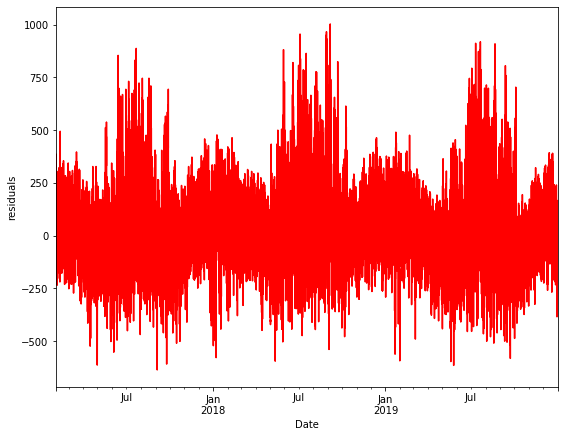

In [3]:
ax1 = train_df['residuals'].plot(color = 'red', figsize=(9,7))
ax1.set_ylabel('residuals')
ax1.set_xlabel('Date')
plt.show()

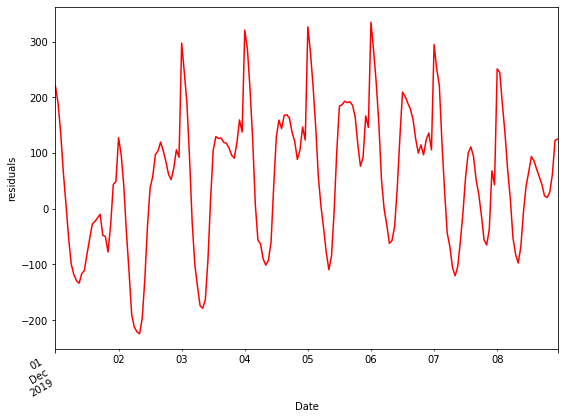

In [4]:
fig, ax = plt.subplots()
df = train_df['2019-12-01':'2019-12-08']
df['residuals'].plot(color = 'red', figsize=(9,7), ylabel='residuals', xlabel='Date', ax=ax)
fig.autofmt_xdate()
plt.show()

Build an Exponential Smoothing model on the residuals that does not incorporate trend but does incorporate a 24-hour seasonal effect.

    The statsmodels library in Python has some great functionality for this with the ExponentialSmoothing function.
    Obtain the predicted values of your residuals on your training data set from this model.
    Add these predicted residuals to your predictions of energy usage from your linear regression to obtain your new dynamic model’s energy predictions.
    Calculate the training MAPE from these new predictions. Notice any improvement?
    Forecast out the next 744 hours of residuals (the month of January 2020). Add these to your test data set prediction from the linear regression to obtain your January 2020 predictions.
 

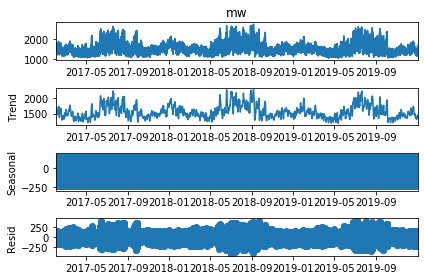

In [5]:
seasonal_decompose(train_df['mw']).plot();

In [6]:
last_month_hours = 31 * 24
train_data = train_df.iloc[:-last_month_hours]
test_data = train_df.iloc[-last_month_hours:]

In [7]:
span = 24 # The model will consider the last 24 hours weighted average for forecasting
alpha = 2/(span+1)
model = SimpleExpSmoothing(train_data['residuals']).fit(smoothing_level=alpha)
test_predictions = model.forecast(last_month_hours).rename('SES Forecast')

/Users/todd/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [8]:
rms_error = np.sqrt(mean_squared_error(test_data['residuals'],test_predictions))
print("RMS Error is ",rms_error)

RMS Error is  162.14718245913718


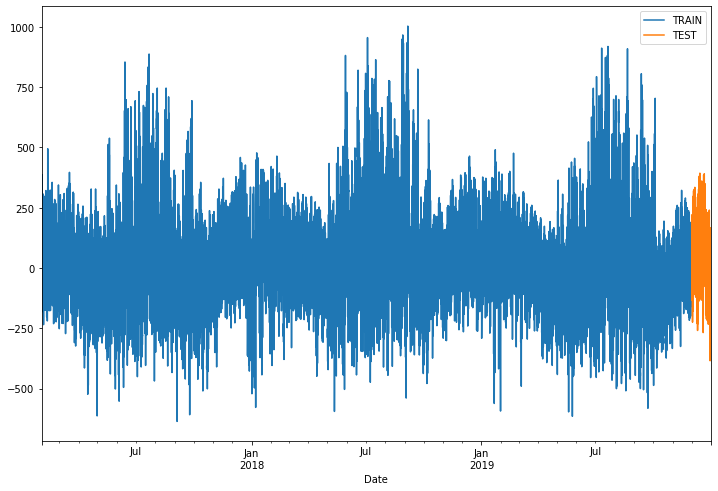

In [9]:
train_data['residuals'].plot(legend=True,label='TRAIN')
test_data['residuals'].plot(legend=True,label='TEST',figsize=(12,8))

In [10]:
test_df = pd.read_csv('timeseries_test.preds.csv', sep='\t', index_col='Date', parse_dates=True)
# test_df['Date'] = pd.to_datetime(test_df['Date'])

In [11]:
span = 24 # The model will consider the last 24 hours weighted average for forecasting
alpha = 2/(span+1)
model = SimpleExpSmoothing(train_df['residuals']).fit(smoothing_level=alpha)
test_predicted_residuals = model.forecast(len(test_df)).rename('SES Forecast')

/Users/todd/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [12]:
test_df['preds2'] = test_df['preds'] + test_predicted_residuals
test_df['predicted_residuals'] = test_predicted_residuals

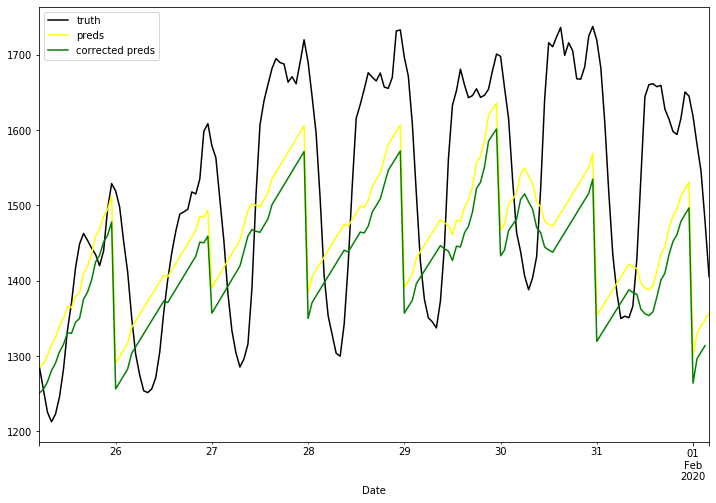

In [13]:
zoom = 24 * 7
test_df[-zoom:]['mw'].plot(legend=True, label='truth', color='black')
test_df[-zoom:]['preds'].plot(legend=True, label='preds', color='yellow')
test_df[-zoom:]['preds2'].plot(legend=True, label='corrected preds', figsize=(12,8), color='green')

In [14]:
residuals = test_df['mw'] - test_df['preds2']
tmp = np.abs(residuals / test_df['mw']) 
mape = 1/len(test_df) * np.sum(tmp * 100) 
print(f"MAPE: {mape}")

MAPE: 8.659000538534526


Build a seasonal ARIMA model on the residuals that doesn’t incorporate trend but does incorporate a 24-hour seasonal effect.

The statsmodels library in Python has some great functionality for this with the SARIMAX function.
A good model to start with would have two autoregressive terms, one seasonal difference (remember that seasons are 24 hours), and one seasonal moving average term. This model is also called an ARIMA(2, 0, 0)(0, 1, 1, 24) model.
This is a good starting point. Feel free to play around by changing the model from there! 
Obtain the predicted values of your residuals on your training data set from this model.
Add these predicted residuals to your predictions of energy usage from your linear regression to obtain your new dynamic model’s energy predictions.
    Calculate the training MAPE from these new predictions. Notice any improvement over the naïve model? How about your previous exponential smoothing model?
    Forecast out the next 744 hours of residuals (the month of January 2020). Add these to your test data set prediction from the linear regression to obtain your January 2020 predictions.

In [15]:
sarima_model = SARIMAX(train_df['residuals'], order=(2,0,0), seasonal_order=(0,1,1,24))

/Users/todd/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/Users/todd/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [16]:
span = 24 # The model will consider the last 24 hours weighted average for forecasting
alpha = 2/(span+1)
sarima_model.fit(smoothing_level=alpha)
res = sarima_model.fit(disp=False)
print(res.summary())

                                      SARIMAX Results                                       
Dep. Variable:                            residuals   No. Observations:                25531
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 24)   Log Likelihood             -127407.958
Date:                              Tue, 12 Jan 2021   AIC                         254823.917
Time:                                      22:56:00   BIC                         254856.504
Sample:                                  02-01-2017   HQIC                        254834.454
                                       - 12-31-2019                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2888      0.003    388.723      0.000       1.282       1.295
ar.L2         -0.34

In [17]:
test_predicted_residuals2 = res.forecast(len(test_df))

In [18]:
# test_df['preds3'] = test_df['preds'] + test_predicted_residuals2
test_df['predicted_residuals2'] = test_predicted_residuals2

preds3 = test_df['preds'] + test_predicted_residuals2
test_df['preds3'] = preds3
residuals3 = test_df['mw'] - preds3 
tmp = np.abs(residuals3 / test_df['mw']) 
mape = 1/len(test_df) * np.sum(tmp * 100) 
print(f"second set of corrected predictions, MAPE: {mape}")

second set of corrected predictions, MAPE: 5.643242841960849


Ensemble your two residual forecasts from above to obtain a new residual forecast.

    A lot of times (but not always), ensembling multiple forecasts together can reduce error beyond what either model’s forecast could do alone.
    Average the two predictions of the residuals in your training data set from the exponential smoothing and seasonal ARIMA models.
    Add these new averaged predicted residuals to your predictions of energy usage from your linear regression to obtain your new dynamic model’s energy predictions.
    Calculate the training MAPE from these new ensembled predictions. Notice any improvement over the naïve model? How about your previous two models?
    Average the two forecasts of residuals (the month of January 2020). Add these to your test data set prediction from the linear regression to obtain your January 2020 ensemble predictions.

In [19]:
test_df 

,DATE,mw,year,month,weekday,hour,temp,temp2,temp_norm,temp_hour,temp_month,preds,preds2,predicted_residuals,predicted_residuals2,preds3
Date,,,,,,,,,,,,,,,,
2020-01-01 01:00:00,2020-01-01 01:00:00,1565.014,2020,1,2,1,31,1.415075,-1.189569,-1.189569,-1.189569,1399.742037,1365.489961,-34.252077,173.549918,1573.291955
2020-01-01 02:00:00,2020-01-01 02:00:00,1515.905,2020,1,2,2,29,1.678463,-1.295555,-2.591111,-1.295555,1436.432307,1402.180230,-34.252077,122.048495,1558.480802
2020-01-01 03:00:00,2020-01-01 03:00:00,1474.519,2020,1,2,3,30,1.543961,-1.242562,-3.727687,-1.242562,1430.409739,1396.157663,-34.252077,48.978097,1479.387837
2020-01-01 04:00:00,2020-01-01 04:00:00,1421.717,2020,1,2,4,30,1.543961,-1.242562,-4.970249,-1.242562,1438.824567,1404.572490,-34.252077,-34.324389,1404.500178
2020-01-01 05:00:00,2020-01-01 05:00:00,1363.428,2020,1,2,5,31,1.415075,-1.189569,-5.947846,-1.189569,1433.941655,1399.689579,-34.252077,-110.457680,1323.483976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-01 00:00:00,2020-02-01 00:00:00,1618.484,2020,2,5,0,34,1.062116,-1.030590,-0.000000,-2.061180,1298.266808,1264.014731,-34.252077,223.535357,1521.802165
2020-02-01 01:00:00,2020-02-01 01:00:00,1580.925,2020,2,5,1,32,1.291805,-1.136576,-1.136576,-2.273152,1330.665481,1296.413405,-34.252077,186.879263,1517.544744
2020-02-01 02:00:00,2020-02-01 02:00:00,1545.354,2020,2,5,2,32,1.291805,-1.136576,-2.273152,-2.273152,1339.350462,1305.098386,-34.252077,136.009951,1475.360414


In [20]:
avg_residuals = test_df['predicted_residuals'] + test_df['predicted_residuals2'] /len(test_df)

In [22]:
test_df['preds4'] = test_df['preds'] + avg_residuals

In [23]:
residuals4 = test_df['mw'] - test_df['preds4'] 
tmp = np.abs(residuals4 / test_df['mw']) 
mape = 1/len(test_df) * np.sum(tmp * 100) 
print(f"second set of corrected predictions, MAPE: {mape}")

second set of corrected predictions, MAPE: 8.6536135346718
